# Newspaper data

Newspaper data will be used for three different purposes:

- **Extracting protest events**, which will represent the **treatment**. For this, only articles that contain keywords such as "protest", "demonstration", etc. are relevant. Text of the whole articles may not be necessary, snippets around the keywords may suffice.
- **Representing unknown confounders**. Here I want to use the full texts of all articles of one or multiple or all newspapers. This is much more data than for the above purpose, and finding a good data source here will be challenging.
- **Extracting discourse characteristics**, which will represent the **effect**. Here it could be useful to use full texts and apply topic models, but counting keywords could also suffice, at least for a first try.

I want to focus:

- **on Germany**: because I am familiar with the language, the politics, and the protest movements of thus country,
- **during the past decade** (2013-2022): because I want to reduce time bias as much as possible, and because I believe that for the last decade there will be good coverage of online media,
- **on all protest movements**, and especially the climate justice movements: mostly because I am personally interested in them,
- **via either print or online news** or both: wherever I can find the best consistent dataset.

## How much data is needed?

Before comparing potential data sources, it is useful to estimate how much data I will need to retrieve, because this will have an effect on the cost and thereby the feasibility of some sources.

In [1]:
import random
from datetime import date, timedelta

from faker import Faker
from tqdm.notebook import tqdm

seed = 20230116
Faker.seed(seed)

# generate random dates in the past decade
dates = [
    Faker().date_between(start_date="-10y", end_date=date(2022, 12, 31))
    for i in range(10)
]
dates

[datetime.date(2021, 6, 22),
 datetime.date(2017, 3, 2),
 datetime.date(2016, 2, 24),
 datetime.date(2017, 5, 29),
 datetime.date(2021, 12, 16),
 datetime.date(2022, 12, 2),
 datetime.date(2013, 11, 21),
 datetime.date(2019, 10, 26),
 datetime.date(2016, 5, 9),
 datetime.date(2021, 7, 9)]

In [2]:
from src.data.news.sources.bing import search as bing_search
from src.data.news.sources.google import search as google_search
from src.data.news.sources.mediacloud import search as mediacloud_search

engines = [
    ("google", google_search),
    ("mediacloud", mediacloud_search),
]

sites = [  # some hand-selected news sites, with their mediacloud id
    "bild.de",  # national, low
    "spiegel.de",  # national, medium
    "zeit.de",  # national, high
    "bz-berlin.de",  # local, capital
    "stuttgarter-zeitung.de",  # local, west
    "lvz.de",  # local, east
]

In [3]:
import pandas as pd

data = []
for date in dates[:3]:
    for site in sites:
        for name, engine in engines:
            print(f"{name} {site} {date}")
            n_articles = len(engine(None, date=date, newspaper=site))
            data.append(
                {
                    "engine": name,
                    "site": site,
                    "date": str(date),
                    "n_articles": n_articles,
                }
            )
df = pd.DataFrame(data)
df.head()

google bild.de 2021-06-22
mediacloud bild.de 2021-06-22
16f451c1aa96837d15d23103d61bb52d
google spiegel.de 2021-06-22
mediacloud spiegel.de 2021-06-22
e0c86f2c3112d7686970c17d07d0af34
google zeit.de 2021-06-22
mediacloud zeit.de 2021-06-22
858d28c3035355f024d9387c42224d16
google bz-berlin.de 2021-06-22
mediacloud bz-berlin.de 2021-06-22
11973a4bda78cf57d2ca8009d7e1b618
google stuttgarter-zeitung.de 2021-06-22
mediacloud stuttgarter-zeitung.de 2021-06-22
4836511f7b883ca876b1b696196f05de
google lvz.de 2021-06-22
mediacloud lvz.de 2021-06-22
dd550251b566aa452fbabb34b91b6cde
google bild.de 2017-03-02
mediacloud bild.de 2017-03-02
f81350f3813940df381f2fe9bc779458
google spiegel.de 2017-03-02
mediacloud spiegel.de 2017-03-02
b9632ed32508b3012d14847025263806
google zeit.de 2017-03-02
mediacloud zeit.de 2017-03-02
5afc3692b68c81df826383814a5f22e4
google bz-berlin.de 2017-03-02
mediacloud bz-berlin.de 2017-03-02
d15525a0c75baa31c33e60166dac332a
google stuttgarter-zeitung.de 2017-03-02
mediaclou

,engine,site,date,n_articles
0,google,b,2021-06-22,76
1,mediacloud,b,2021-06-22,155
2,google,s,2021-06-22,84
3,mediacloud,s,2021-06-22,94
4,google,z,2021-06-22,76


In [4]:
import altair as alt

alt.Chart(df).mark_boxplot().encode(
    x="engine:N",
    y="n_articles:Q",
    column="site:N",
)

/Users/david/Repositories/protest-impact/.venv/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

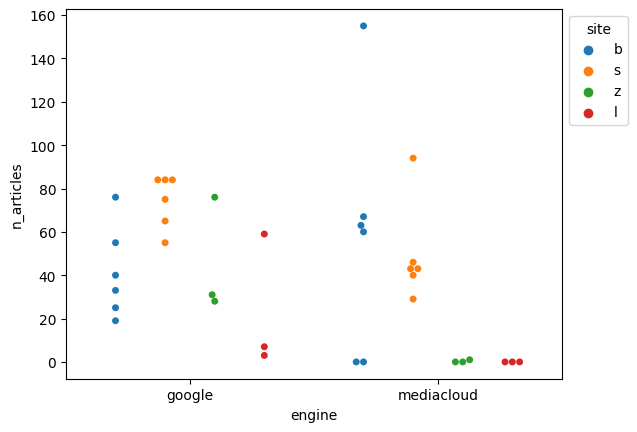

In [5]:
import seaborn as sns

ax = sns.swarmplot(data=df, x="engine", y="n_articles", hue="site", dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [6]:
df[df.engine == "google"].groupby("site").n_articles.mean()

site
b    41.333333
l    23.000000
s    74.500000
z    45.000000
Name: n_articles, dtype: float64

In [7]:
df[df.engine == "google"].n_articles.mean()

49.94444444444444

One newspaper publishes roughly $32 \cdot 365 \approx 10{\small,}000$ articles per year, so 100k articles for the envisioned 10-year period. Most search engines have a limit of 100 articles per query, thus this corresponds to 1000 queries per newspaper. The minimum amount of different newspapers might be 5, so that different regions could be compared. More regions (say, 10) with 3 newspapers on average, plus 20 national newspapers, would result in 50 newspapers, thus 50k queries.

Under the assumption (not verified) that an article contains bout 1 Kilobyte of text, that would amount to full text data in the order of 5GB.

## Which data sources are suitable?



The following potential sources of newspaper articles have been considered. The 💰 symbol gives the price for 50k queries.

Data suitability:
🟡 perfect
🟠 okay
🔴 not suitable

- 🟡 [Media Cloud](https://mediacloud.org/) - open source portal with many corpora, very convenient, quality should be tested, completely free
- 🟠 Google News via 3rd party API (max. 100 results/query each)
	- 🟠 ScaleSerp - upgradable plans, basically pay-per-use 💰 150€
	- 🟠 SerpMaster 💰 200€
	- 🟠 ZenSerp 💰 200€
	- 🔴 DataForSeo - 5x price increase for using "site:" 💰 500€ for instant responses / 150€ for queued responses
	- 🔴 SerpAPI: 50€/5k calls/month, 250€/30k calls/month
- 🟠 [mediastack](https://mediastack.com/documentation) - 25€/10k calls/month, 100€/50k calls/month, 250€/250k calls/month, max. 100 results/query 💰 100€
- 🟠 [News API](https://newsapi.ai/) (by EventRegistry) - 90€/5k calls/month, 400€/50k calls/month, max. 100 results/query 💰 400€
- 🟠 Bing Web Search - fewer newspapers than on Google 💰 150€
- 🟠 archives of single newspapers
	- 🟡 [Zeit](https://www.zeit.de/2023/index) - free epubs of the print version
	- 🟠 [Süddeutsche](https://www.sueddeutsche.de/archiv/politik/2016) - article lists for each year/topic, could be scraped
	- 🟠 [Welt](https://www.welt.de/schlagzeilen) - article lists for each day, could be scraped
	- 🟠 Bild - article lists for each day, could be scraped
	- 🔴 [FAZ](https://www.faz-rechte.de/anwendungen-services/text-und-datamining/) - can send them statistical queries, no full-text access
	- 🔴 Tagesspiegel - cannot find archive
- 🟠 Internet Archive - could be scraped, bigger newspaper = more coverage: Zeit coverage goes ~10y back, Süddeutsche ~5y, Berliner Zeitung ~3y, Gäubote ~1y
- 🟠 Deutsches Referenzkorpus - print publications until 2020, access via [KorAP](https://korap.ids-mannheim.de/doc/api), is conceived for retrieving linguistic statistics, retrieving full-texts seems possible but would be hacky
- 🔴 Bing News - only 14 days into the past
- 🔴 LexisNexis / Nexis Uni - great selection of print newspapers with full texts, no proper API
- 🔴 Genios (via Berlin Library) - great content, but no API, even BibBot uses Puppeteer for access of single articles
- 🔴 Google Search / News - possible to search just by site and date, but no API
- 🔴 RSS feeds - very shallow history
- 🔴 Reuters archives - can only find images and videos, no press statements
- 🔴 DPA - cannot find archive

## How is the quality of the MediaCloud data?

### How consistent is the MediaCloud data?

In [ ]:
data = []
for name, engine in engines:
    for site in tqdm(sites):
        for i, start_date in enumerate(dates):
            start_date_ = start_date - timedelta(
                days=start_date.weekday()
            )  # choose monday before the date
            num_days = 14
            end_date = start_date_ + timedelta(days=14)
            results = engine(None, date=start_date_, end_date=end_date, newspaper=site)
            for num_days_ in range(num_days):
                date_ = start_date_ + timedelta(days=num_days_)
                n_articles = len([r for r in results if r.date == date_])
                data.append(
                    {
                        "engine": name,
                        "site": site[0],
                        "date": date_,
                        "n_articles": n_articles,
                        "start_date": start_date_,
                    }
                )

df = pd.DataFrame(data)
df.head()

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df["start_date"] = pd.to_datetime(df["start_date"])

alt.Chart(df, width=2000, height=50).mark_bar().encode(
    x="date:T",
    y="n_articles:Q",
    row="site:N",
    color="start_date:N",
)

/Users/david/Repositories/protest-impact/.venv/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
alt.Chart(df[df["engine"] == "mediacloud"], width=1000, height=50).mark_bar().encode(
    x="date:O",
    y="n_articles:Q",
    row="site:N",
    color="start_date:N",
)

alt.Chart(...)

### How does the Media Cloud data compare to other data sources?

### Can all data be collected?

## Can all full texts be scraped?

Scraping is done via [`download.py`](../../protest_impact/data/news/download.py). Results:

More than 3.5GB of full-text newspaper articles from 22 diverse German newspapers (national and regional), covering the past decade. The metadata comes from MediaCloud.org and Google News, and full-text articles have been scraped from the provided links.

Below the start date of good and consistent coverage is shown (at least 250 articles per month consistently):

## National

- bild.de: 2013
- faz.net: 2013
- focus.de: 2014
- n-tv.de: 2013
- rnd.de: 2020
- spiegel.de: 2013
- stern.de: 2013
- sueddeutsche.de: 2013
- t-online.de: 2014
- tagesspiegel.de: 2014
- welt.de: 2013
- zeit.de: 2013

**≥11 national newspapers with ≥9 years coverage** (from the top 10 most read + top 4 most cited newspapers)

## Local

- augsburger-allgemeine.de: 2013
- bz-berlin.de: 2018
- haz.de: 2018
- lvz.de: 2018
- noz.de: 2014
- rp-online.de: 2016
- rundschau-online.de: 2021
- saechsische.de: 2019
- stuttgarter-zeitung.de: 2014
- weser-kurier.de: 2014

**≥8 regional newspapers with ≥5 years coverage, ≥4 with ≥9 years coverage** (criteria: most read, biggest cities, previous studies)